# Train house price predictor

The objective of this notebook is to train a model that predicts housing prices. That model will be used in the Flask app to predict a price for an ad on Daft.ie. The user copy-pastes the ad URL into the browser, the app scrapes the ad from Daft.ie, transforms and enriches the data and returns a predicted price. 

The first part of this notebook explores the data and the second part trains the model. This notebook uses the MLpipeline class created in 'MLpipeline.py'. Some functions in that file will also be used live when predicting a price for a user of the app.

The scraping and enriching has already been done and the data is stored in "data/df_ads_mapdata.csv"

In [11]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from MLpipeline import MLpipeline

# This makes sure the that the plotly plots can be seen on github (static)
# Remove this to get the interactive plots
pio.renderers.default = "svg"


## Loading data
Loading the data and making a list of variables to be considered as features for the model.

In [3]:
df_ads = pd.read_csv('data/df_ads_mapdata.csv')

xlist = ['surface','area','property_type','ber_classification',
         'selling_type','price_type','month','bathrooms','beds',
         'dist_to_centre','caferestaurants', 'churches', 'health', 
         'parks', 'platforms', 'pubs','schools', 'shops', 'sports', 
         'stations', 'latitude', 'longitude','parking']
all_vars = xlist
all_vars.append('price')

print(df_ads.info())

print("Number of rows: {}".format(df_ads.shape[0]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16498 entries, 0 to 16497
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EDNAME              15428 non-null  object 
 1   ad_id               16498 non-null  int64  
 2   ad_ids              16420 non-null  object 
 3   advertising_type    6286 non-null   object 
 4   area                16497 non-null  object 
 5   bathrooms           16416 non-null  float64
 6   beds                16416 non-null  float64
 7   ber_classification  12617 non-null  object 
 8   caferestaurants     16498 non-null  int64  
 9   churches            16498 non-null  int64  
 10  county              16498 non-null  object 
 11  currency            16416 non-null  object 
 12  environment         16498 non-null  object 
 13  facility            5580 non-null   object 
 14  health              16498 non-null  int64  
 15  latitude            16498 non-null  float64
 16  long

The info above shows the size of the dataset and shows that for some variables we have a considerable amount of missing values: 

- price type
- BER classification (this is an energy rating)
- surface

Missing values will be imputed in the pipeline further on, but we should explore what is going on.


## Cleaning data
When the app pulls an ad from the Daft.ie directly, this data needs to be cleaned as well. Therefore we need to define a function that does this cleaning. This function is defined in 'MLpipeline.py' and is called in this notebook later. Imputation of missing values is part of the preprocessing in the ML pipeline.

Some of the cleaning, like removing observations, is only done for the purposes of training the model and does not need to be done everytime a new ad is pulled from the website. These cleaning actions will be done directly here in the notebook.

The price type seems to only be non-missing if it is different from the norm, e.g. a region or a 'from' price. We can recode the missings to a 'normal' category. This is done in MLpipeline.py. The different prices types will have an influence on the price but because it is a significant number we keep the data. We include the variable in the model, however.
 

In [4]:
df_ads.price_type.value_counts()

region            3181
from               437
on-application     120
asking-price        57
excess               1
Name: price_type, dtype: int64

For the BER I cant discover anything unusual. Most likely the missing ratings are for properties of which the owner did not test the energy efficiency. The missing values will be imputed in the ML pipeline.

In [5]:
df_ads.ber_classification.value_counts()

D1                     1604
D2                     1581
C3                     1485
C2                     1393
C1                     1194
E1                     1017
F                       845
G                       838
E2                      819
B3                      795
A3                      372
B2                      337
SINo666of2006exempt     120
A2                      113
B1                       95
A1                        7
C3E1                      1
E2G                       1
Name: ber_classification, dtype: int64


The property type shows that most of the properties on the website are apartments, (semi-)detached, terraced or end-of-terrace properties. There are also some smaller categories: bungalows, duplexes, sites, studios and houses. Sites will be removed from the data for training the model. The aim is to predict prices for properties, not land. 

In [6]:
print(df_ads.property_type.value_counts())

df_ads = df_ads.drop(df_ads[df_ads.property_type=='site'].index)

print("Number of rows: {}".format(df_ads.shape[0]))

apartment         4522
semi-detached     4198
terraced          3464
detached          1672
end-of-terrace    1370
bungalow           423
duplex             375
site               210
townhouse          148
house               17
studio              17
Name: property_type, dtype: int64
Number of rows: 16288


The selling type could considerably influence the price. Prices for houses that are auctioned will not be comparable to houses that are not auctioned. Only 'private-treaty' is kept and so are missing values which effectively imputes them as 'private-treaty'.  

In [7]:
print(df_ads.selling_type.value_counts())

df_ads = df_ads[(df_ads!="auction") & (df_ads!='private-tender') & (df_ads!='tender')]
df_ads = df_ads.drop('selling_type',axis=1)

print("Number of rows: {}".format(df_ads.shape[0]))

private-treaty    15986
auction             137
private-tender        8
tender                5
Name: selling_type, dtype: int64
Number of rows: 16288


Checking for outliers in the numerical variables

In [8]:
df_ads.loc[:,df_ads.columns.isin(all_vars)].describe(percentiles=[.001, .01, .05, .25, .5, .75, .95, .99, 0.999]).applymap(lambda x: format(x, ".1f")).transpose()

,count,mean,std,min,0.1%,1%,5%,25%,50%,75%,95%,99%,99.9%,max
bathrooms,16206.0,1.9,1.1,0.0,0.0,0.0,1.0,1.0,2.0,2.0,4.0,5.0,11.0,29.0
beds,16206.0,2.9,1.2,0.0,0.0,1.0,1.0,2.0,3.0,3.0,5.0,6.0,12.8,29.0
caferestaurants,16288.0,6.7,21.8,0.0,0.0,0.0,0.0,0.0,1.0,4.0,31.0,78.0,279.0,319.0
churches,16288.0,1.2,1.9,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,11.0,13.0,16.0
health,16288.0,0.2,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,5.0
latitude,16288.0,53.4,0.1,53.1,53.2,53.2,53.3,53.3,53.3,53.4,53.5,53.6,53.6,53.6
longitude,16288.0,-6.3,0.1,-6.6,-6.5,-6.5,-6.4,-6.3,-6.3,-6.2,-6.1,-6.1,-6.1,-6.0
parks,16288.0,2.7,3.3,0.0,0.0,0.0,0.0,1.0,2.0,4.0,10.0,15.0,22.0,38.0
platforms,16288.0,11.8,10.5,0.0,0.0,0.0,0.0,6.0,10.0,15.0,26.0,55.0,112.7,144.0
price,16102.0,459633.4,394755.0,19995.0,125000.0,160000.0,195000.0,270000.0,360000.0,520000.0,995000.0,1950000.0,4634850.0,10000000.0


There seem to be some extreme cases for the number of beds and bathrooms. Removing properties with more than 10 bedrooms or bathrooms. Also the surface area (square meters) can be rather high in a few cases which is either a mistake or it is properties with a signficant amount of land which is not surface area of the property itself. These will be removed because they would be very atypical.

In [9]:
df_ads = df_ads[df_ads.bathrooms<=10]
df_ads = df_ads[df_ads.beds<=10]
df_ads = df_ads[(df_ads.surface<=1000) | pd.isnull(df_ads.surface)]

print("Number of rows: {}".format(df_ads.shape[0]))

Number of rows: 16150


The distribution of the price is heavily skewed. House prices around 300k are most common but in our dataset it goes up to 10 million euros. 

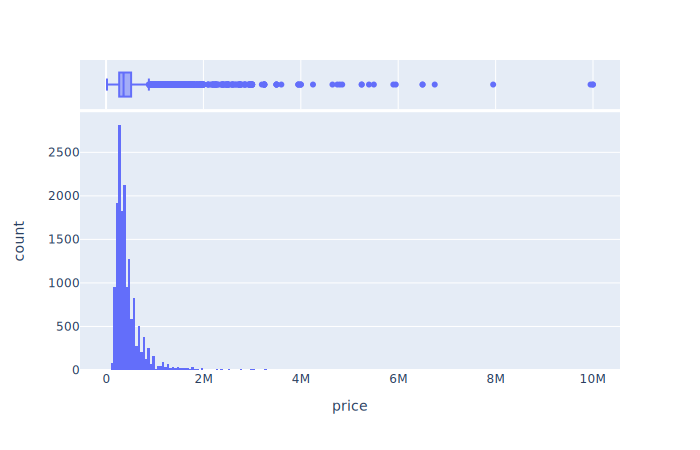

In [10]:
px.histogram(x=df_ads.price, nbins=200, marginal="box", labels={"x": "price"})


Some properties are very cheap. The minimum price in the dataset is actually 20k. Less 0.1% of the data has a price of around 125k or lower. Anything under a 100k is probably an atypical property so they will be removed. Similarly, houses priced over 3 million euros will also be removed. Finally, dropping rows with missing prices. The plot below shows the price distribution after cleaning. 

For the estimation its probably better to take the log of the prices which returns a distribution that is much closer to the normal distribution.

In [10]:
df_ads = df_ads[(df_ads.price>100000) & (df_ads.price<3000000)]       
df_ads = df_ads.dropna(subset=['price'])

print("Number of rows: {}".format(df_ads.shape[0]))

px.histogram(x=df_ads.price, nbins=200, marginal="box", labels={"x": "price"}, log_x=True)

Number of rows: 15999


In [11]:
df_ads = df_ads.reset_index()
print("Number of rows: {}".format(df_ads.shape[0]))

Number of rows: 15999


## Training model

Instantiating a machine learning pipeline for each estimator: linear regression, elastic net, randomforest and gradient boosting. The y variable is the log of 'price' and the variables defined in xlist are features. Some of them are created in the prep_data step.

All estimators are tuned using Grid search with 3 folds.

In [12]:
xlist = ['surface','area','property_type','ber_classification','price_type',
         'month','bathrooms','beds',
         'dist_to_centre','caferestaurants', 'churches', 'health', 
         'parks', 'platforms', 'pubs','schools', 'shops', 'sports', 
         'stations', 'latitude', 'longitude','parking']

numeric_features = ['surface','bathrooms', 'beds', 'dist_to_centre', 'caferestaurants', 'churches', 'health', 'parks', 'platforms', 'pubs', 'schools', 'shops', 'sports', 'stations', 'latitude', 'longitude', 'parking']

categorical_features = xlist.copy()

for x in numeric_features:
    categorical_features.remove(x)

In [13]:
mlp_linreg = MLpipeline(df_ads)

parametersGrid = {}

mlp_linreg.set_estimator(LinearRegression(), 
                         parametersGrid, xlist,
                         numeric_features, categorical_features)
mlp_linreg.run()


R squared: 0.8535
RMSE: 0.1946
Tuned best parameters: {}


In [26]:
mlp_enet = MLpipeline(df_ads)

parametersGrid = {"estimator__alpha": [0.001,0.01, 0.1,0.5,0.9,1],
                  "estimator__l1_ratio": [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]}

mlp_enet.set_estimator(ElasticNet(max_iter=10000), 
                         parametersGrid, xlist,
                         numeric_features, categorical_features)
mlp_enet.run()


R squared: 0.8433
RMSE: 0.2012
Tuned best parameters: {'estimator__alpha': 0.001, 'estimator__l1_ratio': 0.01}


In [15]:
mlp_rf = MLpipeline(df_ads)

parametersGrid = {'estimator__n_estimators': [700,900,1100,1300,1500],
                  'estimator__max_features': ['auto','log2'],
                  'estimator__min_samples_leaf': [1,5,20,50]}

mlp_rf.set_estimator(RandomForestRegressor(random_state=42), 
                     parametersGrid, xlist,
                     numeric_features, categorical_features) 

mlp_rf.run()

R squared: 0.7959
RMSE: 0.2297
Tuned best parameters: {'estimator__max_features': 'auto', 'estimator__min_samples_leaf': 1, 'estimator__n_estimators': 900}


In [16]:
mlp_xgb = MLpipeline(df_ads)

parametersGrid = {'estimator__n_estimators': [1500,1700,2000,2300,2600],
                  'estimator__max_depth': [1,3,5,7,9,11],
                  'estimator__learning_rate': [0.01,0.1,0.3],
                  'estimator__gamma': [0.0, 0.2, 0.4],
                  'estimator__colsample_bytree': [0.3,0.5,0.7,1]}

mlp_xgb.set_estimator(XGBRegressor(objective='reg:squarederror', random_state=42),
                         parametersGrid, xlist,
                         numeric_features, categorical_features)
mlp_xgb.run()


R squared: 0.8827
RMSE: 0.1741
Tuned best parameters: {'estimator__colsample_bytree': 0.7, 'estimator__gamma': 0.0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 2000}


In [17]:
df0 = pd.DataFrame({'y_pred': mlp_linreg.y_pred,
                    'y_test': mlp_linreg.y_test,
                    'estimator': 'Regression'})

df1 = pd.DataFrame({'y_pred': mlp_enet.y_pred,
                    'y_test': mlp_enet.y_test,
                    'estimator': 'ElasticNet'})

df2 = pd.DataFrame({'y_pred': mlp_rf.y_pred,
                    'y_test': mlp_rf.y_test,
                    'estimator': 'RandomForest'})
              
df3 = pd.DataFrame({'y_pred': mlp_xgb.y_pred,
                    'y_test': mlp_xgb.y_test,
                    'estimator': 'GradientBoost'})

df = df0.append(df1, ignore_index=True)
df = df.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)

fig = px.scatter(df, x="y_test", y="y_pred", color="estimator", 
                marginal_y="box",
                labels={'y_test':'Observed',
                        'y_pred': 'Predicted'})
                        
fig.update_traces(marker=dict(size=6,
                              opacity=0.5))
fig.show()

Model fit seems to be comparable for the different estimators. Generally it seems that overfitting is not an issue, e.g. linear regression works better than elastic net and the best paramters of the gridsearch for elastic net are those very close to linear regression. Gradient stochastic boosting outperforms the others slightly so this model will be used to predict housing prices.

In [18]:
mlp_xgb.save_model('model/model.pkl')

Pipeline(memory=None,
         steps=[('prep_data',
                 prep_data(xlist=['surface', 'area', 'property_type',
                                  'ber_classification', 'price_type', 'month',
                                  'bathrooms', 'beds', 'dist_to_centre',
                                  'caferestaurants', 'churches', 'health',
                                  'parks', 'platforms', 'pubs', 'schools',
                                  'shops', 'sports', 'stations', 'latitude',
                                  'longitude', 'parking'])),
                ('preprocessor',
                 ColumnTransformer(n_jobs=N...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, gamma=0.0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=2000, n_jobs=